# Multi-AOI Vegetation Indices with Dask (NDVI, EVI, SAVI)

This notebook loads four small AOIs across Australia and computes NDVI/EVI/SAVI time-series using ODC-STAC with Dask. It then clips each AOI and plots/export zonal statistics for all polygons.

## 1) Install packages

In [1]:
%pip install -q pystac-client planetary-computer odc-stac xarray geopandas rioxarray rasterio matplotlib dask[distributed]

^C
Note: you may need to restart the kernel to use updated packages.


## 2) Imports and Dask

In [ ]:
from pystac_client import Client as StacClient
import planetary_computer
import xarray as xr
from odc.stac import stac_load
import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray
import numpy as np
from shapely.geometry import shape, mapping
from dask.distributed import Client as DaskClient, LocalCluster
import warnings
warnings.filterwarnings('ignore')
xr.set_options(keep_attrs=True);
cluster = LocalCluster(n_workers=8, threads_per_worker=16)
client = DaskClient(cluster); client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 128,Total memory: 55.95 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:52642,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 128
Started: Just now,Total memory: 55.95 GiB
Comm: tcp://127.0.0.1:52669,Total threads: 16
Dashboard: http://127.0.0.1:52688/status,Memory: 6.99 GiB
Nanny: tcp://127.0.0.1:52645,


2025-08-12 08:57:38,424 - distributed.protocol.core - CRITICAL - Failed to deserialize
Traceback (most recent call last):
  File "c:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\Lib\site-packages\distributed\protocol\core.py", line 175, in loads
    return msgpack.loads(
           ^^^^^^^^^^^^^^
  File "c:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\Lib\site-packages\msgpack\fallback.py", line 136, in unpackb
    raise ExtraData(ret, unpacker._get_extradata())
msgpack.exceptions.ExtraData: unpack(b) received extra data.
2025-08-12 08:57:38,431 - distributed.core - ERROR - Exception while handling op register-client
Traceback (most recent call last):
  File "c:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\Lib\site-packages\distributed\core.py", line 834, in _handle_comm
    result = await result
             ^^^^^^^^^^^^
  File "c:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\Lib\site-packages\distributed\scheduler.py", line 5949, in add_client


## 3) STAC catalog

In [2]:
catalog = StacClient.open('https://planetarycomputer.microsoft.com/api/stac/v1/', modifier=planetary_computer.sign_inplace)
catalog

<Client id=microsoft-pc>

## 4) Load multi-AOI GeoJSON and bounding box

In [3]:
# aoi_path = 'australia_4_polygons.geojson'
aoi_path = "../data/forest283.geojson"
gdf = gpd.read_file(aoi_path).to_crs(4326)
# Dissolve for bbox search but keep individual polygons for zonal stats
bbox = gdf.dissolve().total_bounds.tolist()
gdf

,OBJECTID,UNIT_KEY,PRUK,FOREST,LOG_AREA,CPT_ID,CPT_NO,SUB,SLASH,CPTCOMM,...,Shape__Area,Shape__Length,PRIM_SPEC_COM,SEC_SPEC_COM,TCPT,SHORT_DESC,LOCATION,ST_ASSETID,T1GIS_ID,geometry
0,6068,283_BIDWILLII_4_1,283_BIDWILLII_4,283,BIDWILLII,4,4,,,,...,1.008489e-05,0.020720,96,0,004,BIDWILLII_4_1,SF283\BIDWILLII\004,ST005076,5671,"POLYGON ((152.15976 -26.77157, 152.15968 -26.7..."
1,6069,283_BIDWILLII_4_3,283_BIDWILLII_4,283,BIDWILLII,4,4,,,,...,3.328304e-06,0.008107,96,0,004,BIDWILLII_4_3,SF283\BIDWILLII\004,ST005078,6680,"POLYGON ((152.1705 -26.77303, 152.1704 -26.772..."
2,6070,283_BIDWILLII_4_1,283_BIDWILLII_4,283,BIDWILLII,4,4,,,,...,2.456796e-05,0.042623,96,0,004,BIDWILLII_4_1,SF283\BIDWILLII\004,ST005076,5671,"POLYGON ((152.16206 -26.77525, 152.162 -26.775..."
3,6071,283_BIDWILLII_4_2,283_BIDWILLII_4,283,BIDWILLII,4,4,,,,...,3.716238e-06,0.007995,96,0,004,BIDWILLII_4_2,SF283\BIDWILLII\004,ST005077,10668,"POLYGON ((152.17142 -26.77423, 152.17141 -26.7..."
4,6072,283_BIDWILLII_4_3,283_BIDWILLII_4,283,BIDWILLII,4,4,,,,...,3.959014e-06,0.008075,96,0,004,BIDWILLII_4_3,SF283\BIDWILLII\004,ST005078,6680,"POLYGON ((152.16735 -26.77325, 152.16717 -26.7..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
853,27401,283_BIDWILLII_202_20,283_BIDWILLII_202,283,BIDWILLII,202,202,,,WAS 3,...,3.894076e-05,0.032304,96,0,202,BIDWILLII_202_20,SF283\BIDWILLII\202,ST018428,18419,"POLYGON ((152.17427 -26.78668, 152.17373 -26.7..."
854,27810,283_MUDDY_215_67,283_MUDDY_215,283,MUDDY,215,215,,,"WAS 11A,14pt,17pt",...,1.572491e-08,0.000493,3,0,215,MUDDY_215_67,SF283\MUDDY\215,ST018411,18402,"POLYGON ((152.18825 -26.79313, 152.18815 -26.7..."
855,27811,283_MUDDY_215_67,283_MUDDY_215,283,MUDDY,215,215,,,"WAS 11A,14pt,17pt",...,3.445424e-08,0.001230,3,0,215,MUDDY_215_67,SF283\MUDDY\215,ST018411,18402,"POLYGON ((152.18838 -26.79639, 152.18839 -26.7..."
856,27812,283_MUDDY_215_20,283_MUDDY_215,283,MUDDY,215,215,,,"WAS 11A,14pt,17pt",...,5.016224e-05,0.037444,96,0,215,MUDDY_215_20,SF283\MUDDY\215,ST018415,18406,"POLYGON ((152.18835 -26.79021, 152.18812 -26.7..."


## 5) Search Landsat 8 C2 L2 (2015–2024) <20% cloud

In [4]:
results = catalog.search(
    collections=['landsat-c2-l2'],
    bbox=bbox,
    datetime=['2024-10-01', '2024-12-31'],
    query={'eo:cloud_cover': {'lt': 20}, 'platform': {'in': ['landsat-8']}}
)
items = list(results.get_items())
len(items), items[0] if items else None

(1, <Item id=LC08_L2SP_090078_20241025_02_T1>)

## 6) Load data cube (blue, red, nir) with chunks

In [6]:
bands = ['blue','red','nir08']
chunks = {'time': 1, 'x': 1024, 'y': 1024}
data = stac_load(items=items, bands=bands, bbox=bbox, groupby='time', chunks=chunks)
data

<xarray.Dataset> Size: 24TB
Dimensions:      (y: 60451, x: 98822, time: 662)
Coordinates:
  * y            (y) float64 484kB -2.049e+06 -2.049e+06 ... -3.862e+06
  * x            (x) float64 791kB 1.302e+05 1.302e+05 ... 3.095e+06 3.095e+06
    spatial_ref  int32 4B 32651
  * time         (time) datetime64[ns] 5kB 2024-10-01T01:30:47.875149 ... 202...
Data variables:
    blue         (time, y, x) uint16 8TB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    red          (time, y, x) uint16 8TB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    nir08        (time, y, x) uint16 8TB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>

## 7) Aggregate to monthly (median)

In [ ]:
data_monthly = data.resample(time='1M').median()
data_monthly

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x103ab70e0>>
Traceback (most recent call last):
  File "/Users/ben/miniconda3/envs/sklearn-env/lib/python3.13/site-packages/ipykernel/ipkernel.py", line 781, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
2025-08-11 12:22:56,166 - distributed.nanny - ERROR - Worker process died unexpectedly
Process Dask Worker process (from Nanny):
Traceback (most recent call last):
  File "/Users/ben/miniconda3/envs/sklearn-env/lib/python3.13/asyncio/runners.py", line 118, in run
    return self._loop.run_until_complete(task)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^
  File "/Users/ben/miniconda3/envs/sklearn-env/lib/python3.13/asyncio/base_events.py", line 725, in run_until_complete
    return future.result()
           ~~~~~~~~~~~~~^^
  File "/Users/ben/miniconda3/envs/sklearn-env/lib/python3.13/site-packages/distributed/nanny.py"

## 8) Compute indices (NDVI, EVI, SAVI)

In [ ]:
nir = data_monthly['nir08']; red = data_monthly['red']; blue = data_monthly['blue']
NDVI = (nir - red) / (nir + red)
EVI = 2.5 * (nir - red) / (nir + 6.0 * red - 7.5 * blue + 1.0)
SAVI = (1.0 + 0.5) * (nir - red) / (nir + red + 0.5)
NDVI, EVI, SAVI

(<xarray.DataArray (time: 3, y: 60451, x: 98822)> Size: 143GB
 dask.array<truediv, shape=(3, 60451, 98822), dtype=float64, chunksize=(1, 466, 466), chunktype=numpy.ndarray>
 Coordinates:
   * y            (y) float64 484kB -2.049e+06 -2.049e+06 ... -3.862e+06
   * x            (x) float64 791kB 1.302e+05 1.302e+05 ... 3.095e+06 3.095e+06
     spatial_ref  int32 4B 32651
   * time         (time) datetime64[ns] 24B 2024-10-31 2024-11-30 2024-12-31
 Attributes:
     nodata:   0,
 <xarray.DataArray (time: 3, y: 60451, x: 98822)> Size: 143GB
 dask.array<truediv, shape=(3, 60451, 98822), dtype=float64, chunksize=(1, 466, 466), chunktype=numpy.ndarray>
 Coordinates:
   * y            (y) float64 484kB -2.049e+06 -2.049e+06 ... -3.862e+06
   * x            (x) float64 791kB 1.302e+05 1.302e+05 ... 3.095e+06 3.095e+06
     spatial_ref  int32 4B 32651
   * time         (time) datetime64[ns] 24B 2024-10-31 2024-11-30 2024-12-31
 Attributes:
     nodata:   0,
 <xarray.DataArray (time: 3, y: 60451,

: 

## 9) Zonal stats per AOI and combined plotting

In [ ]:
# Clip each AOI and compute means over x/y
from shapely.geometry import mapping as shp_mapping
aoi_crs = gdf.crs or 'EPSG:4326'
records = []
for idx, row in gdf.iterrows():
    name = row.get('name', f'AOI_{idx}')
    geoms = [shp_mapping(row.geometry)]
    ndvi_m = NDVI.rio.clip(geoms, aoi_crs, drop=True).mean(dim=['y','x']).rename('NDVI')
    evi_m = EVI.rio.clip(geoms, aoi_crs, drop=True).mean(dim=['y','x']).rename('EVI')
    savi_m = SAVI.rio.clip(geoms, aoi_crs, drop=True).mean(dim=['y','x']).rename('SAVI')
    ds = xr.concat([ndvi_m, evi_m, savi_m], dim='metric').assign_coords(metric=['NDVI','EVI','SAVI'])
    ds = ds.to_series().reset_index(name='value').rename(columns={'metric':'metric'})
    ds['aoi'] = name
    records.append(ds)
import pandas as pd
df = pd.concat(records, ignore_index=True)
# Plot: one figure with lines for each AOI per metric
fig, ax = plt.subplots(figsize=(10,6))
for metric in ['NDVI','EVI','SAVI']:
    pivot = df[df.metric==metric].pivot(index='time', columns='aoi', values='value')
    pivot.plot(ax=ax, linewidth=1.2, alpha=0.8)
ax.set_title('AOI Vegetation Indices (Monthly Means)')
ax.set_ylabel('Index value')
plt.legend(title='AOI', bbox_to_anchor=(1.02,1), loc='upper left')
plt.tight_layout()
df.head()

## 10) Export combined CSV

In [ ]:
df.to_csv('AOI_multi_indices_timeseries.csv', index=False)
'Wrote AOI_multi_indices_timeseries.csv'

### Optional: wide-format CSVs and clearer plots

- Export wide CSVs per metric (rows=time, columns=AOIs).
- Export a single wide CSV with MultiIndex columns (metric, AOI).
- Provide per-metric subplots for a cleaner visualization.


In [ ]:
# Build wide-format tables per metric (rows=time, columns=AOIs)
import pandas as pd

metrics = ['NDVI','EVI','SAVI']
wide_tables = {}
for metric in metrics:
    wide = df[df.metric == metric].pivot(index='time', columns='aoi', values='value')
    wide_tables[metric] = wide
    wide.to_csv(f'AOI_{metric}_timeseries_wide.csv', index_label='time')

# Also export a single CSV with a two-level column index (metric, aoi)
wide_multi = pd.concat(wide_tables, axis=1)
wide_multi.to_csv('AOI_all_metrics_timeseries_wide_multiindex.csv', index_label='time')

# Per-metric subplots for clearer visualization
fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)
for ax, metric in zip(axes, metrics):
    wide_tables[metric].plot(ax=ax)
    ax.set_title(f'{metric} (Monthly Means)')
    ax.set_ylabel(metric)
    ax.legend(title='AOI', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
'Exported wide-format CSVs and rendered per-metric plots'

## 6) Polygon-by-polygon processing (memory-safe, Dask-friendly)

Instead of loading data for the dissolved bounding box of all AOIs (which can be huge),
this section iterates over each polygon:
- Search STAC only within that polygon's bbox
- Load with ODC-STAC using Dask chunks
- Aggregate monthly and compute NDVI/EVI/SAVI
- Clip to the polygon and compute spatial means
- Append to a combined results table

This approach reduces memory pressure and avoids building a massive Dask graph.
You can skip the previous bulk loading/aggregation cells if you use this section.


In [5]:
# Parameters for search and chunks
collections = ['landsat-c2-l2']
datetime_range = ['2023-06-01', '2024-12-31']
cloud_filter = {'eo:cloud_cover': {'lt': 20}, 'platform': {'in': ['landsat-8']}}
bands = ['blue','red','nir08']
chunks = {'time': 1, 'x': 2048, 'y': 2048}

# Container for all AOI results
import pandas as pd
records_pp = []

# Iterate polygons
for idx, row in gdf.iterrows():
    aoi_name = row.get('name', f'AOI_{idx}')
    geom = row.geometry
    # Per-AOI bbox search
    minx, miny, maxx, maxy = geom.bounds
    aoi_bbox = [minx, miny, maxx, maxy]

    # Search STAC for this AOI only
    res = catalog.search(collections=collections, bbox=aoi_bbox, datetime=datetime_range, query=cloud_filter)
    items_aoi = list(res.get_items())
    if not items_aoi:
        print(f'No items for {aoi_name}; skipping')
        continue

    # Load data lazily with Dask for the AOI
    data_aoi = stac_load(items=items_aoi, bands=bands, bbox=aoi_bbox, groupby='time', chunks=chunks)

    # Monthly aggregation
    dm = data_aoi.resample(time='1M').median()

    # Compute indices
    nir = dm['nir08']; red = dm['red']; blue = dm['blue']
    ndvi = (nir - red) / (nir + red)
    evi = 2.5 * (nir - red) / (nir + 6.0 * red - 7.5 * blue + 1.0)
    savi = (1.0 + 0.5) * (nir - red) / (nir + red + 0.5)

    # Clip to polygon and compute spatial means
    from shapely.geometry import mapping as shp_mapping
    geoms = [shp_mapping(geom)]
    aoi_crs = gdf.crs or 'EPSG:4326'
    ndvi_m = ndvi.rio.clip(geoms, aoi_crs, drop=True).mean(dim=['y','x']).rename('NDVI')
    evi_m  = evi.rio.clip(geoms, aoi_crs, drop=True).mean(dim=['y','x']).rename('EVI')
    savi_m = savi.rio.clip(geoms, aoi_crs, drop=True).mean(dim=['y','x']).rename('SAVI')

    # Stack to long records and append AOI name
    ds = xr.concat([ndvi_m, evi_m, savi_m], dim='metric').assign_coords(metric=['NDVI','EVI','SAVI'])
    df_aoi = ds.to_series().reset_index(name='value')
    df_aoi['aoi'] = aoi_name
    records_pp.append(df_aoi)

# Combine all AOIs
if records_pp:
    df_pp = pd.concat(records_pp, ignore_index=True)
    # Save both long and wide formats
    df_pp.to_csv('AOI_multi_indices_timeseries_polygon_by_polygon_long.csv', index=False)
    # Wide per metric
    for metric in ['NDVI','EVI','SAVI']:
        wide = df_pp[df_pp.metric==metric].pivot(index='time', columns='aoi', values='value')
        wide.to_csv(f'AOI_{metric}_timeseries_polygon_by_polygon_wide.csv', index_label='time')
    # Combined wide with MultiIndex columns
    wide_multi = pd.concat({m: df_pp[df_pp.metric==m].pivot(index='time', columns='aoi', values='value') for m in ['NDVI','EVI','SAVI']}, axis=1)
    wide_multi.to_csv('AOI_all_metrics_polygon_by_polygon_wide_multiindex.csv', index_label='time')
    print('Polygon-by-polygon export complete.')
else:
    print('No AOI results generated.')


FutureCancelledError: ('concatenate-f742101843bdaef6a742febe48a1feb7', 0, 7) cancelled for reason: scheduler-connection-lost.
Client lost the connection to the scheduler. Please check your connection and re-run your work.

## 7) Plot time-series for all AOIs and indices

This plots NDVI, EVI, and SAVI as separate time-series subplots, with one line per AOI.
It uses the polygon-by-polygon results if available (df_pp), otherwise falls back to the earlier df.


'Rendered per-metric time-series plots for all AOIs'

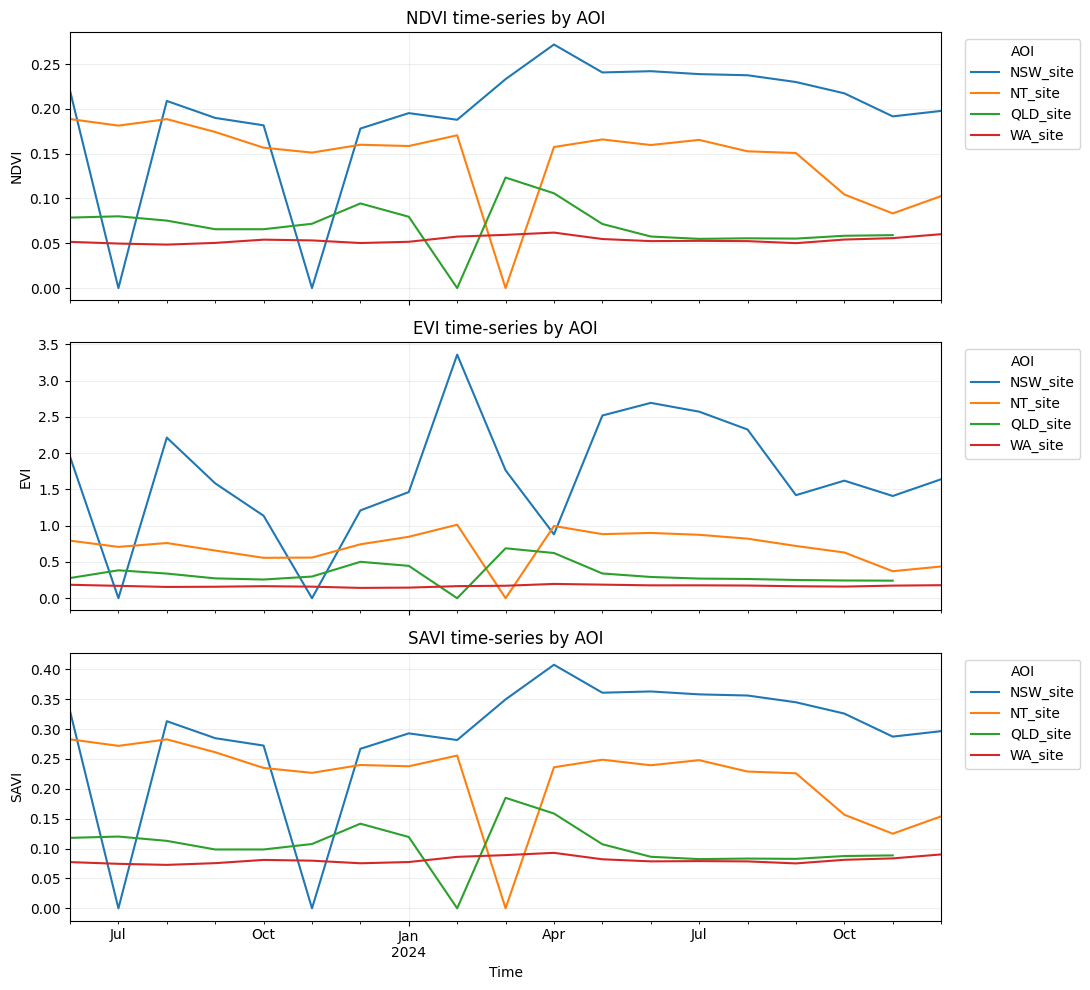

In [5]:
# Choose the results DataFrame: prefer polygon-by-polygon (df_pp), else fallback to df
import pandas as pd

data_src = None
try:
    # df_pp is produced by polygon-by-polygon section
    if isinstance(df_pp, pd.DataFrame) and {'time','aoi','metric','value'}.issubset(df_pp.columns):
        data_src = df_pp.copy()
except NameError:
    pass

if data_src is None:
    try:
        if isinstance(df, pd.DataFrame) and {'time','aoi','metric','value'}.issubset(df.columns):
            data_src = df.copy()
    except NameError:
        pass

if data_src is None:
    raise RuntimeError('No results DataFrame found. Run either the polygon-by-polygon section or the earlier zonal stats block first.')

# Ensure time is datetime
data_src['time'] = pd.to_datetime(data_src['time'])

metrics = ['NDVI','EVI','SAVI']
fig, axes = plt.subplots(len(metrics), 1, figsize=(11, 10), sharex=True)
for ax, metric in zip(axes, metrics):
    wide = data_src[data_src.metric == metric].pivot(index='time', columns='aoi', values='value')
    wide.sort_index().plot(ax=ax, linewidth=1.5)
    ax.set_title(f'{metric} time-series by AOI')
    ax.set_ylabel(metric)
    ax.grid(True, alpha=0.2)
    ax.legend(title='AOI', bbox_to_anchor=(1.02, 1), loc='upper left')

axes[-1].set_xlabel('Time')
plt.tight_layout()
'Rendered per-metric time-series plots for all AOIs'